# Using CT for thermosensitivity analysis: Synthetic data

The first examples uses synthetic (aka fake) to illustrate a typical thermo-sensitivity analysis.

In [1]:
import matplotlib.pyplot as plt
from energy_toolbox.synthetic import DateSynthTSConsumption

In [2]:
my_synthtisor = DateSynthTSConsumption(
    base_energy=1e3,
    ts_cool=5e1,
    ts_heat=1e2,
    noise_std=1e2,
    t_ref_cool=24,
    t_ref_heat=16,
)

data = my_synthtisor.random_consumption(start="2021-09-01", end="2024-04-17", size=None)

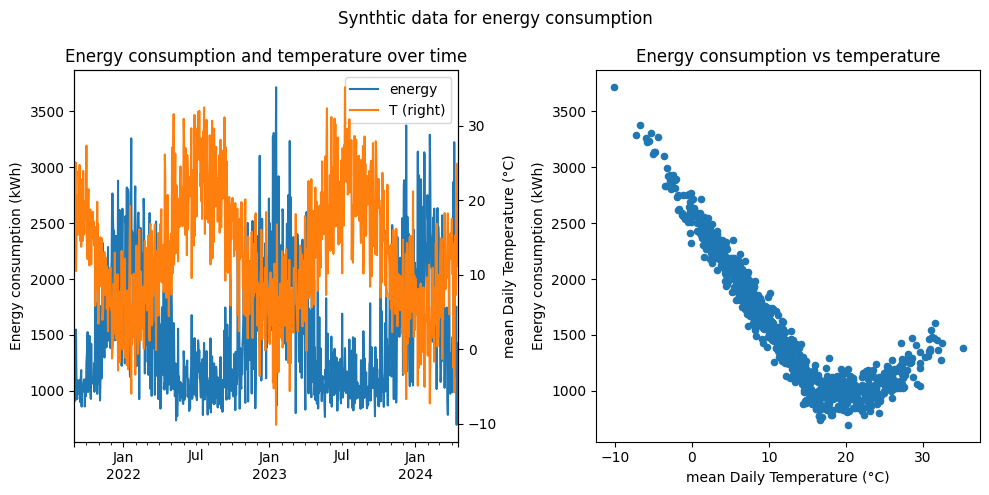

In [3]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))
data[["energy"]].plot(ax=ax1)
data[["T"]].plot(ax=ax1, secondary_y=True)
ax1.set_ylabel("Energy consumption (kWh)")
ax1.right_ax.set_ylabel("mean Daily Temperature (°C)")

data.plot.scatter(x="T", y="energy", ax=ax2)
ax2.set_xlabel("mean Daily Temperature (°C)")
ax2.set_ylabel("Energy consumption (kWh)")
ax1.set_title("Energy consumption and temperature over time")
ax2.set_title("Energy consumption vs temperature")
fig.suptitle("Synthtic data for energy consumption")
fig.tight_layout()

# Thermo-sensitivity analysis

The main objective of the analysis is to explain the impact of the temperature over the energy.
In the case of the synthetic model, it relates to
- finding the threshold temperatures for heating and cooling
- finding the three coefficients $E_0$, $TS_{cooling}$ and $TS_{heating}$ such that
    $$ E = E_0 + TS_{cooling} * DD_{cooling}  + TS_{heating} * DD_{heating} $$ 

In [4]:
import pandas as pd
from energy_toolbox.weather.degree_days import dd_compute

In [5]:
dd_heating = dd_compute(data["T"], reference=16, type="heating", method="mean")
dd_cooling = dd_compute(data["T"], reference=24, type="cooling", method="mean")
data_with_dd = pd.concat([data, dd_heating, dd_cooling], axis=1)
data_with_dd

,base,thermosensitive,residual,energy,heating,...,T,DJU_heating,DJU_cooling,heating_degree_days,cooling_degree_days
2021-09-01,1000.0,0.000000,161.687440,1161.687440,0.000000,...,22.224711,0.000000,0.000000,0.000000,0.000000
2021-09-02,1000.0,61.227791,13.102712,1074.330503,61.227791,...,15.387722,0.612278,0.000000,0.612278,0.000000
2021-09-03,1000.0,11.223187,-100.234398,910.988789,0.000000,...,24.224464,0.000000,0.224464,0.000000,0.224464
2021-09-04,1000.0,52.883927,-10.972745,1041.911181,0.000000,...,25.057679,0.000000,1.057679,0.000000,1.057679
2021-09-05,1000.0,551.955698,-3.561074,1548.394624,551.955698,...,10.480443,5.519557,0.000000,5.519557,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2024-04-13,1000.0,0.000000,-304.763257,695.236743,0.000000,...,20.235867,0.000000,0.000000,0.000000,0.000000
2024-04-14,1000.0,487.612615,-61.604903,1426.007713,487.612615,...,11.123874,4.876126,0.000000,4.876126,0.000000
2024-04-15,1000.0,45.981166,102.534803,1148.515969,0.000000,...,24.919623,0.000000,0.919623,0.000000,0.919623
2024-04-16,1000.0,214.349285,-31.728673,1182.620613,214.349285,...,13.856507,2.143493,0.000000,2.143493,0.000000


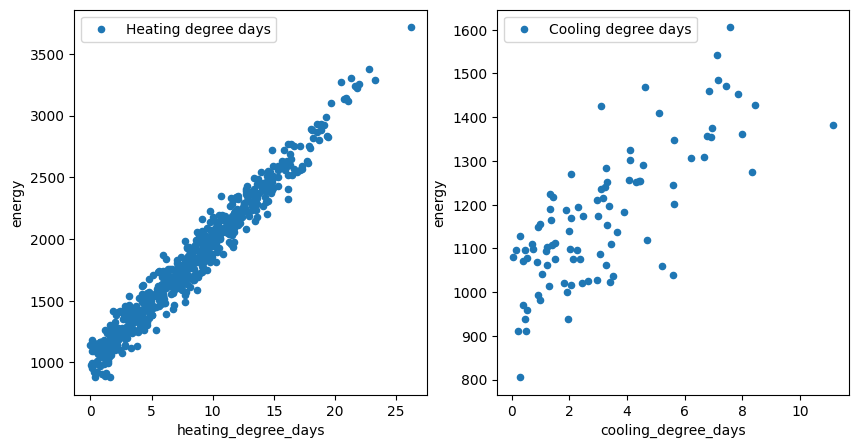

In [6]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))
data_with_dd[data_with_dd["heating_degree_days"] > 0].plot.scatter(
    x="heating_degree_days", y="energy", label="Heating degree days", ax=ax1
)
data_with_dd[data_with_dd["cooling_degree_days"] > 0].plot.scatter(
    x="cooling_degree_days", y="energy", ax=ax2, label="Cooling degree days"
);

# Automatic calibration of the degree days model

The degree days are computed relative to a reference (aka base) temperature.

This reference temperature corresponds to the temperature below (resp. above) which the heating (resp. cooling) is required. 
Hence, it depends on the building and the heating/cooling system.

Accordingly, the reference temperature is a parameter to be calibrated from the energy signature of the building.

In [7]:
from energy_toolbox.thermosensitivity import ThermoSensitivity

In [8]:
data.head()

,base,thermosensitive,residual,energy,heating,cooling,T,DJU_heating,DJU_cooling
2021-09-01,1000.0,0.000000,161.687440,1161.687440,0.000000,0.000000,22.224711,0.000000,0.000000
2021-09-02,1000.0,61.227791,13.102712,1074.330503,61.227791,0.000000,15.387722,0.612278,0.000000
2021-09-03,1000.0,11.223187,-100.234398,910.988789,0.000000,11.223187,24.224464,0.000000,0.224464
2021-09-04,1000.0,52.883927,-10.972745,1041.911181,0.000000,52.883927,25.057679,0.000000,1.057679
2021-09-05,1000.0,551.955698,-3.561074,1548.394624,551.955698,0.000000,10.480443,5.519557,0.000000


In [9]:
my_synthtisor = DateSynthTSConsumption(
    base_energy=1e3,
    ts_cool=5e1,
    ts_heat=1e2,
    noise_std=1e2,
    t_ref_cool=24,
    t_ref_heat=16,
)

data = my_synthtisor.random_consumption(start="2021-09-01", end="2024-04-17", size=None)

ts = ThermoSensitivity(
    energy_data=data["energy"],
    temperature_data=data["T"],
    frequency="1D",
    degree_days_type="both",
    degree_days_computation_method="mean",  # here the provided data is already in daily frequency. Hence the only mean
)

In [10]:
ts.calibrate_base_temperatures(xatol=1e-1, disp=True)

t0=13.8197, 15578.97, 325449.40
t0=16.1803, 10359.68, 325449.40
t0=17.6393, 12327.60, 325449.40
t0=16.2137, 10369.52, 325449.40
t0=15.9972, 10355.47, 325449.40
t0=15.1655, 11106.30, 325449.40
t0=16.0797, 10346.18, 325449.40
t0=16.1130, 10347.20, 325449.40
t0=16.0463, 10349.45, 325449.40

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  0.1 )
t0=23.8197, 9956.21, 24862.48
t0=26.1803, 12241.89, 24862.48
t0=22.3607, 9994.82, 24862.48
t0=23.1410, 9873.23, 24862.48
t0=23.1743, 9869.03, 24862.48
t0=23.3214, 9879.95, 24862.48
t0=23.2305, 9870.35, 24862.48

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  0.1 )


## Fitting thermo-sensitivity model

using the newlly computed degree days, we can fit the thermo-sensitivity model to the energy consumption.

In [11]:
ts.fit()
ts.model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 energy   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                 1.446e+04
Date:                Mon, 23 Sep 2024   Prob (F-statistic):               0.00
Time:                        12:07:38   Log-Likelihood:                -5792.6
No. Observations:                 960   AIC:                         1.159e+04
Df Residuals:                     957   BIC:                         1.161e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
heating_degree_days   100.2894      0.597    168.095      0.000      99.119     101.460
cooling_degree_days    47.8830      2.383     20.093      0.000      43.206      52.560
Intercept             983.3953      4.810    204.463      0.000     973.957     992.834
==============================================================================
Omnibus:                        1.146   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.564   Jarque-Bera (JB):                1.208
Skew:                          -0.080   Prob(JB):                        0.547
Kurtosis:                       2.932   Cond. No.                         11.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

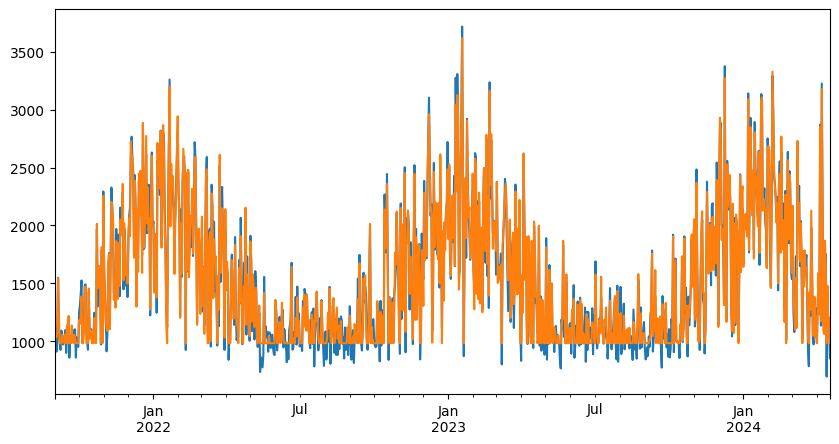

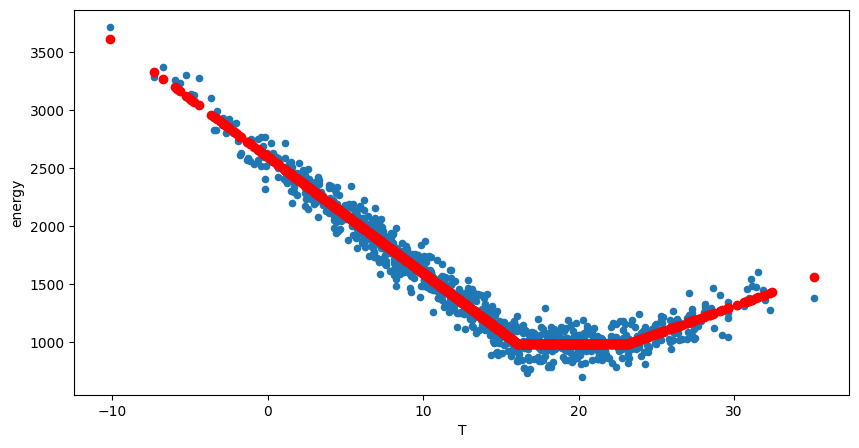

In [12]:
pred = ts.model.predict()

fig, ax = plt.subplots(figsize=(10, 5))
data["energy"].plot(ax=ax, label="Observed")
ax.plot(data.index, pred, label="Predicted")

fig, ax = plt.subplots(figsize=(10, 5))
data.plot.scatter(x="T", y="energy", ax=ax)
ax.scatter(data["T"], ts.model.predict(), label="Predicted", color="r");

## Accessing the performance of the calibration

The performance of the calibration is assessed by the optained value with respect to the actual reference temperature used to generate the synthetic data.

We recall that the synthetic data is generated using the following formula
$$ E = E_0 + TS_{heating} * DD_{heating} + \mathcal{N}(0, \sigma)$$ 



In [13]:
n_test = 500
results = []
my_synthtisor = DateSynthTSConsumption(
    base_energy=1e3,
    ts_cool=5e1,
    ts_heat=1e2,
    noise_std=1e2,
    t_ref_cool=24,
    t_ref_heat=16,
)
for idx in range(n_test):
    data = my_synthtisor.random_consumption(start="2021-09-01", end=None, size=200)
    ts = ThermoSensitivity(
        energy_data=data["energy"],
        temperature_data=data["T"],
        frequency="1D",
    )
    ts.degree_days_computation_method = "mean"
    tref = ts.calibrate_base_temperature(
        dd_type="heating", t0=13, xatol=1e-2, disp=False
    )
    results.append(tref)

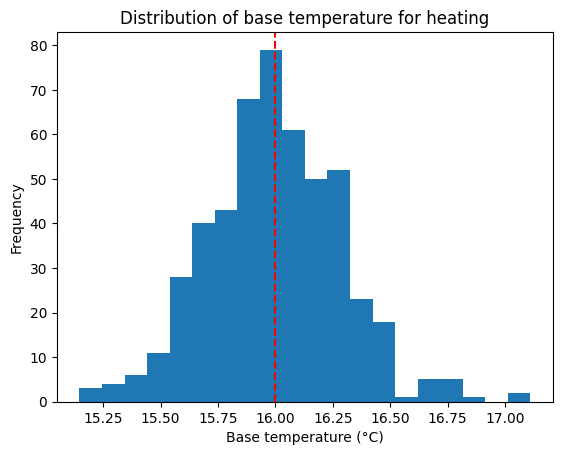

In [14]:
fig, ax = plt.subplots()
ax.hist(results, bins=20)
ax.set_xlabel("Base temperature (°C)")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of base temperature for heating")
ax.axvline(
    x=my_synthtisor.t_ref_heat, color="r", linestyle="--", label="True base temperature"
)

# Automatic detection of the type of thermo sensitivity

In general, it is difficult to know in advance the type of thermo-sensitivity of a building. 
By "type" I mean : does the building heat during cold days or cool during hot days, or both ?

Hence, it is important to be able to detect it automatically.

By setting the type to `"auto"`, the model will try to detect the type of thermo-sensitivity using Spearman correlation p-value.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 energy   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                 1.501e+04
Date:                Mon, 23 Sep 2024   Prob (F-statistic):               0.00
Time:                        12:08:05   Log-Likelihood:                -3582.9
No. Observations:                 960   AIC:                             7172.
Df Residuals:                     957   BIC:                             7186.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
heating_degree_days    10.0186      0.061    164.444      0.000       9.899      10.138
cooling_degree_days     0.4427      0.179      2.475      0.014       0.092       0.794
Intercept             998.4568      0.501   1994.070      0.000     997.474     999.439
==============================================================================
Omnibus:                        1.462   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.481   Jarque-Bera (JB):                1.514
Skew:                          -0.092   Prob(JB):                        0.469
Kurtosis:                       2.939   Cond. No.                         12.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

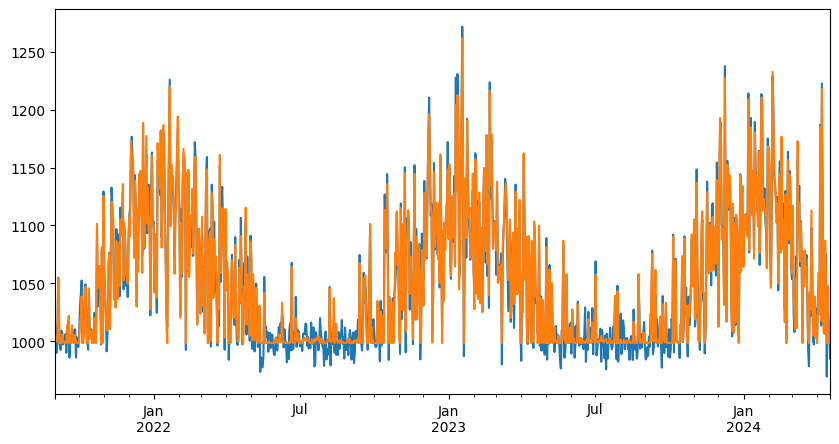

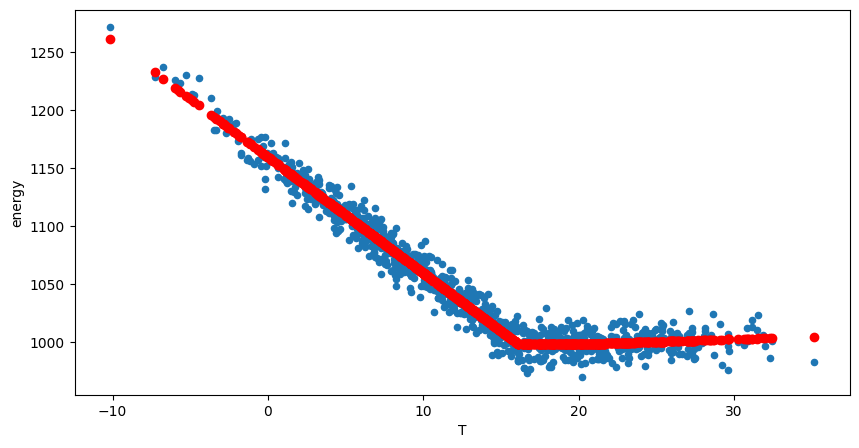

In [15]:
my_synthtisor_heating = DateSynthTSConsumption(
    base_energy=1e3,
    ts_cool=0,
    ts_heat=1e1,
    noise_std=1e1,
    t_ref_cool=24,
    t_ref_heat=16,
    noise_seed=42,
)

data = my_synthtisor_heating.random_consumption(
    start="2021-09-01", end="2024-04-17", size=None
)

ts = ThermoSensitivity(
    energy_data=data["energy"],
    temperature_data=data["T"],
    frequency="1D",
    degree_days_type="auto",
    degree_days_computation_method="mean",
)
ts.fit()
display(ts.model.summary())

pred = ts.model.predict()

fig, ax = plt.subplots(figsize=(10, 5))
data["energy"].plot(ax=ax, label="Observed")
ax.plot(data.index, pred, label="Predicted")

fig, ax = plt.subplots(figsize=(10, 5))
data.plot.scatter(x="T", y="energy", ax=ax)
ax.scatter(data["T"], ts.model.predict(), label="Predicted", color="r")

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 energy   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     30.53
Date:                Mon, 23 Sep 2024   Prob (F-statistic):           4.24e-08
Time:                        12:08:06   Log-Likelihood:                -5793.4
No. Observations:                 960   AIC:                         1.159e+04
Df Residuals:                     958   BIC:                         1.160e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
cooling_degree_days     9.7678      1.768      5.525      0.000       6.298      13.237
Intercept             990.7051      3.453    286.953      0.000     983.930     997.480
==============================================================================
Omnibus:                        1.268   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.530   Jarque-Bera (JB):                1.333
Skew:                          -0.084   Prob(JB):                        0.513
Kurtosis:                       2.927   Cond. No.                         2.14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

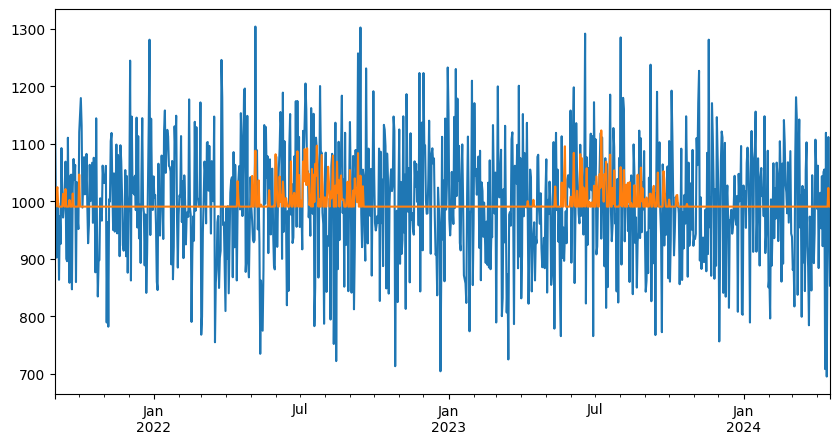

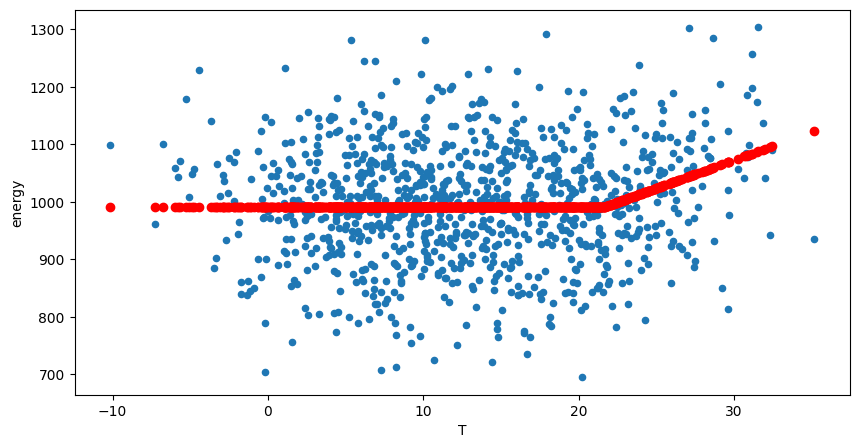

In [16]:
my_synthtisor_cooling = DateSynthTSConsumption(
    base_energy=1e3,
    ts_cool=1e1,
    ts_heat=0,
    noise_std=1e2,
    t_ref_cool=24,
    t_ref_heat=16,
)

data = my_synthtisor_cooling.random_consumption(
    start="2021-09-01", end="2024-04-17", size=None
)

ts = ThermoSensitivity(
    energy_data=data["energy"],
    temperature_data=data["T"],
    frequency="1D",
    degree_days_type="auto",
    degree_days_computation_method="mean",
)
ts.fit()
display(ts.model.summary())

pred = ts.model.predict()

fig, ax = plt.subplots(figsize=(10, 5))
data["energy"].plot(ax=ax, label="Observed")
ax.plot(data.index, pred, label="Predicted")

fig, ax = plt.subplots(figsize=(10, 5))
data.plot.scatter(x="T", y="energy", ax=ax)
ax.scatter(data["T"], ts.model.predict(), label="Predicted", color="r")

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 energy   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     48.12
Date:                Mon, 23 Sep 2024   Prob (F-statistic):           1.22e-20
Time:                        12:08:06   Log-Likelihood:                -5792.5
No. Observations:                 960   AIC:                         1.159e+04
Df Residuals:                     957   BIC:                         1.161e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
heating_degree_days     5.5947      0.595      9.407      0.000       4.428       6.762
cooling_degree_days    10.6731      1.870      5.707      0.000       7.003      14.343
Intercept             985.2591      5.046    195.257      0.000     975.357     995.162
==============================================================================
Omnibus:                        1.270   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.530   Jarque-Bera (JB):                1.331
Skew:                          -0.085   Prob(JB):                        0.514
Kurtosis:                       2.932   Cond. No.                         12.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

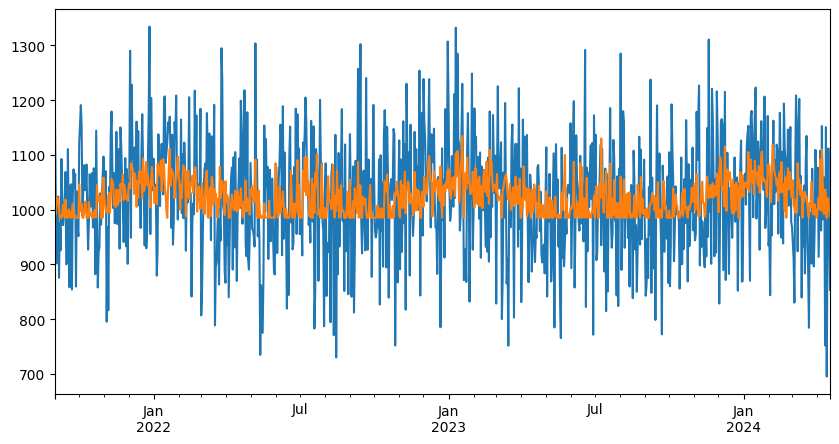

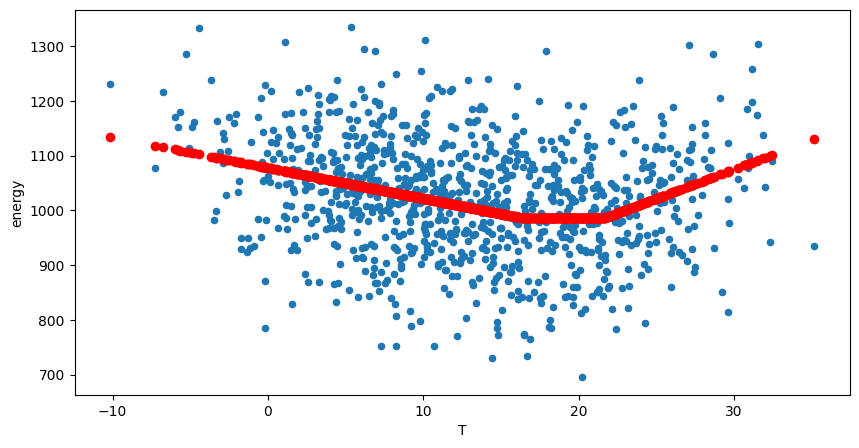

In [17]:
my_synthtisor_both = DateSynthTSConsumption(
    base_energy=1e3,
    ts_cool=1e1,
    ts_heat=5e0,
    noise_std=1e2,
    t_ref_cool=24,
    t_ref_heat=16,
)

data = my_synthtisor_both.random_consumption(start="2021-09-01", end="2024-04-17", size=None)

ts = ThermoSensitivity(
    energy_data=data["energy"],
    temperature_data=data["T"],
    frequency="1D",
    degree_days_type="auto",
    degree_days_computation_method="mean",
)
ts.fit()
display(ts.model.summary())

pred = ts.model.predict()

fig, ax = plt.subplots(figsize=(10, 5))
data["energy"].plot(ax=ax, label="Observed")
ax.plot(data.index, pred, label="Predicted")

fig, ax = plt.subplots(figsize=(10, 5))
data.plot.scatter(x="T", y="energy", ax=ax)
ax.scatter(data["T"], ts.model.predict(), label="Predicted", color="r");

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 energy   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.828
Date:                Mon, 23 Sep 2024   Prob (F-statistic):             0.0507
Time:                        12:08:07   Log-Likelihood:                -1373.1
No. Observations:                 960   AIC:                             2750.
Df Residuals:                     958   BIC:                             2760.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
cooling_degree_days     0.0331      0.017      1.957      0.051      -0.000       0.066
Intercept             999.9146      0.035   2.88e+04      0.000     999.847     999.983
==============================================================================
Omnibus:                        1.428   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.490   Jarque-Bera (JB):                1.484
Skew:                          -0.091   Prob(JB):                        0.476
Kurtosis:                       2.935   Cond. No.                         2.25
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

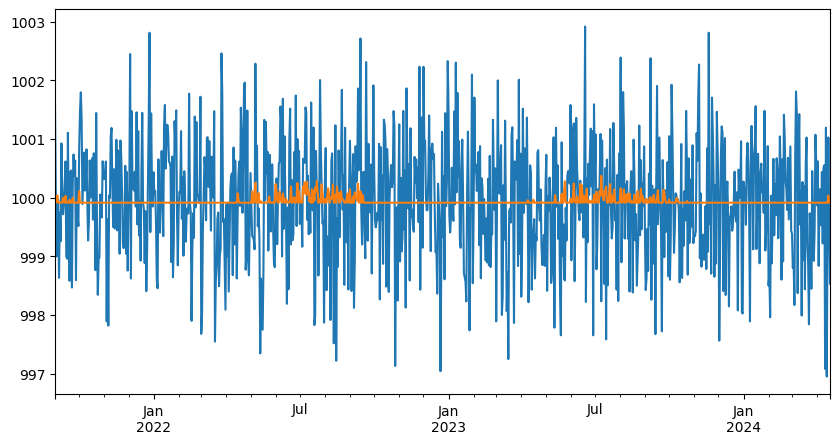

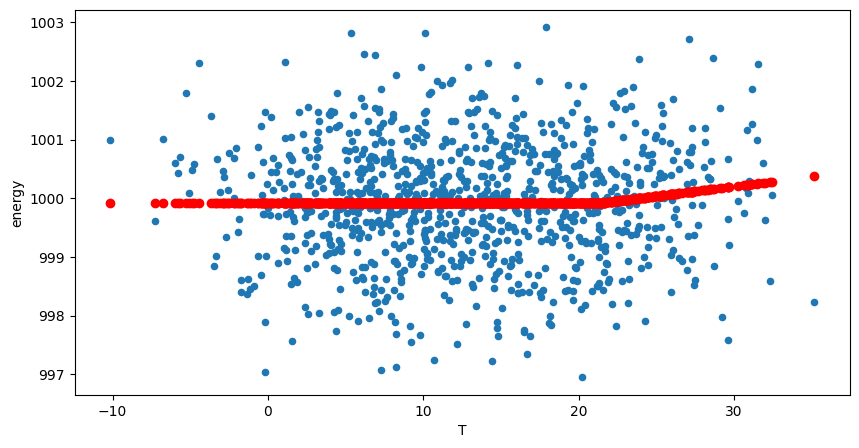

In [18]:
my_synthtisor_both = DateSynthTSConsumption(
    base_energy=1e3,
    ts_cool=0,
    ts_heat=0,
    noise_std=1e0,
    t_ref_cool=24,
    t_ref_heat=16,
)

data = my_synthtisor_both.random_consumption(start="2021-09-01", end="2024-04-17", size=None)

ts = ThermoSensitivity(
    energy_data=data["energy"],
    temperature_data=data["T"],
    frequency="1D",
    degree_days_type="auto",
    degree_days_computation_method="mean",
)
ts.fit()
display(ts.model.summary())

pred = ts.model.predict()

fig, ax = plt.subplots(figsize=(10, 5))
data["energy"].plot(ax=ax, label="Observed")
ax.plot(data.index, pred, label="Predicted")

fig, ax = plt.subplots(figsize=(10, 5))
data.plot.scatter(x="T", y="energy", ax=ax)
ax.scatter(data["T"], ts.model.predict(), label="Predicted", color="r");

In [19]:
ts

ThermoSensitivity(frequency=1D,
        degree_days_type=cooling,
        degree_days_base_temperature={'heating': np.float64(16.48), 'cooling': np.float64(21.3)},
        degree_days_computation_method=mean,
        interseason_mean_temperature=20)

                            OLS Regression Results                            
Dep. Variable:                 energy   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
No. Observations:                 960   F-statistic:                     3.828
Covariance Type:            nonrobust   Prob (F-statistic):             0.0507
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
cooling_degree_days     0.0331      0.017      1.957      0.051      -0.000       0.066
Intercept             999.9146      0.035   2.88e+04      0.000     999.847     999.983

N

# Conclusion

We showed in the notebook how to calibrate the degree days reference temperatures and the thermo-sensitivity model using the synthetic data.

We showed that the calibration is possible and that the performance is resonable.

## Implemented features

- automatic detection of the type of thermo-sensitivity (Heating, Cooling, Mixed), even in the presence of noise.
- automatic calibration of the degree days reference temperature (heating and cooling)
- automatic calibration of the thermo-sensitivity model (heating and cooling)

## Discussion

To continue the analysis, we could study the impact of the noise level on the calibration performance, usualy named Uncertainty Quantification (UQ).

Most of the calibration uses a "intersaison mean temperature" to split the data into heating and cooling periods. By default this value os $20^\circ C$.
It would be interesting to study the impact of this value on the calibration performance.



# Categorical thermo-sensitivity

One of the difficulties of the thermo-sensitivity analysis is the fact that the building behavior can change depending on the day µ(open/closed, week/weekend, holiday, etc).

The following example shows how to use the categorical thermo-sensitivity to model the behavior of a building depending on the day of the week.

In [20]:
from energy_toolbox.synthetic.thermosensitive_consumption import WeekEndSynthTSConsumption

parameters = [
    {
        "base_energy": 1e3,
        "ts_heat": 5e1,
        "ts_cool": 1e2,
        "noise_std": 1e2,
    },
    {
        "base_energy": 1.5e3,
        "ts_heat": 1e1,
        "ts_cool": 6e1,
        "noise_std": 1e2,
    },
]


def open_close_categoriser(series: pd.Series):
    """Return a series of categories based on the day of the week of the index"""
    timestamps = series.index
    return_data = pd.Series(
        data=[
            "Open" if timestamp.weekday() < 5 else "Closed" for timestamp in timestamps
        ],
        index=series.index,
    )
    return return_data


my_cat_synthtisor = WeekEndSynthTSConsumption(
    parameters=parameters,
    t_ref_cool=24,
    t_ref_heat=16,
)
data = my_cat_synthtisor.random_consumption(start="2021-09-01", end="2024-04-17", size=None)
data.head()

,base,thermosensitive,residual,energy,heating,cooling,T,DJU_heating,DJU_cooling,category
2021-09-01,1500.0,0.000000,30.471708,1530.471708,0.000000,0.000000,22.224711,0.000000,0.000000,weekday
2021-09-02,1500.0,6.122779,-103.998411,1402.124369,6.122779,0.000000,15.387722,0.612278,0.000000,weekday
2021-09-03,1500.0,13.467824,75.045120,1588.512944,0.000000,13.467824,24.224464,0.000000,0.224464,weekday
2021-09-04,1000.0,105.767853,30.471708,1136.239561,0.000000,105.767853,25.057679,0.000000,1.057679,weekend
2021-09-05,1000.0,275.977849,-103.998411,1171.979438,275.977849,0.000000,10.480443,5.519557,0.000000,weekend


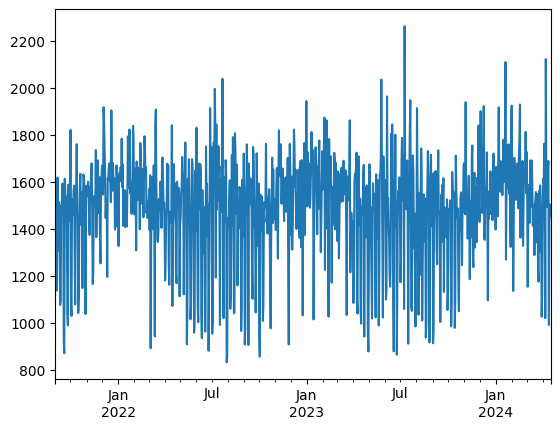

In [21]:
data["energy"].plot();

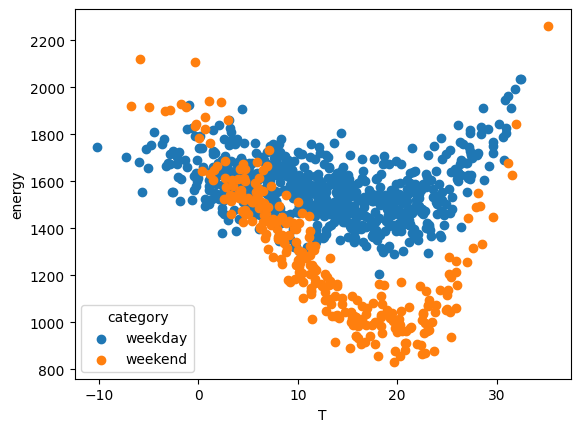

In [22]:
categories = data["category"].unique()
for category in categories:
    subset = data[data["category"] == category]
    plt.scatter(
        subset["T"],
        subset["energy"],
        label=category
    )
plt.xlabel("T")
plt.ylabel("energy")
plt.legend(title="category")
plt.show()

## Using no category

As a first step, we can consider that the building has no category and that the behavior is the same every day.

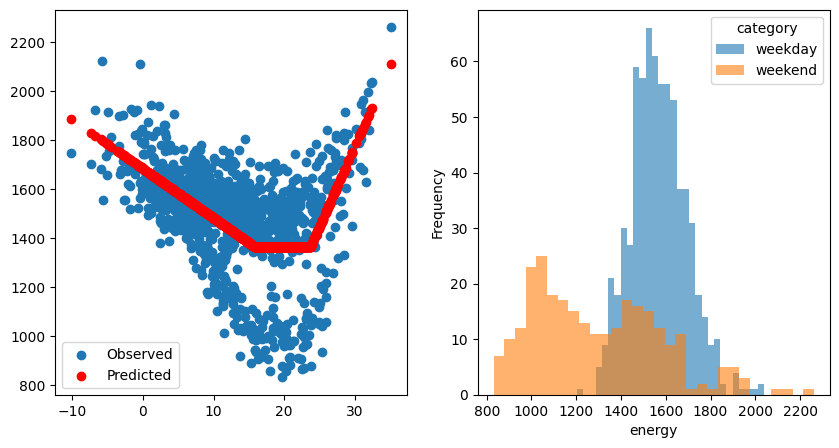

In [23]:
ts_no_cat = ThermoSensitivity(
    energy_data=data["energy"],
    temperature_data=data["T"],
    frequency="1D",
    degree_days_type="auto",
    degree_days_computation_method="mean",
)
ts_no_cat.fit()
# display(ts_no_cat.model.summary())
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(data["T"], data["energy"], label="Observed")
ax1.scatter(data["T"], ts_no_cat.model.predict(), label="Predicted", color="r")
ax1.legend()

error = data["energy"] - ts_no_cat.model.predict()
error = pd.concat([error, data["category"]], axis=1)

categories = data["category"].unique()

for category in categories:
    subset = data[data["category"] == category]
    ax2.hist(
        subset["energy"],
        bins=30,
        alpha=0.6,
        label=category,
        density=False,
    )
ax2.set_xlabel("energy")
ax2.set_ylabel('Frequency')
ax2.legend(title="category");

## Using Categories

Now, lets consider that the building has two categories: week and weekend (fortunatly, we know how the data is generated).


In [24]:
categories = open_close_categoriser(data).rename("category")
categories

2021-09-01      Open
2021-09-02      Open
2021-09-03      Open
2021-09-04    Closed
2021-09-05    Closed
               ...  
2024-04-13    Closed
2024-04-14    Closed
2024-04-15      Open
2024-04-16      Open
2024-04-17      Open
Name: category, Length: 960, dtype: object

In [25]:
from energy_toolbox.thermosensitivity.thermosensitivity import (
    CategoricalThermoSensitivity,
)

ts_cat = CategoricalThermoSensitivity(
    energy_data=data["energy"],
    temperature_data=data["T"],
    categories=categories,
    frequency="1D",
    degree_days_type="auto",
    degree_days_computation_method="mean",
)
ts_cat.fit()

CategoricalThermoSensitivity(frequency=1D,
        degree_days_type=both,
        degree_days_base_temperature={'heating': np.float64(15.89), 'cooling': np.float64(23.72)},
        degree_days_computation_method=mean,
        interseason_mean_temperature=20)

                            OLS Regression Results                            
Dep. Variable:                 energy   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.811
No. Observations:                 960   F-statistic:                     823.0
Covariance Type:            nonrobust   Prob (F-statistic):               0.00
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
heating_degree_days:Closed    50.3594      1.124     44.817      0.000      48.154      52.565
heating_degree_days:Open       9.8679      0.667     14.797 

In [26]:
ts_cat.model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 energy   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     823.0
Date:                Mon, 23 Sep 2024   Prob (F-statistic):               0.00
Time:                        12:08:08   Log-Likelihood:                -5747.7
No. Observations:                 960   AIC:                         1.151e+04
Df Residuals:                     954   BIC:                         1.154e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
heating_degree_days:Closed    50.3594      1.124     44.817      0.000      48.154      52.565
heating_degree_days:Open       9.8679      0.667     14.797      0.000       8.559      11.177
cooling_degree_days:Closed    97.1863      4.569     21.270      0.000      88.219     106.153
cooling_degree_days:Open      52.7087      2.990     17.630      0.000      46.841      58.576
Intercept:Closed             996.3221      8.718    114.280      0.000     979.213    1013.431
Intercept:Open              1499.0469      5.301    282.793      0.000    1488.644    1509.450
==============================================================================
Omnibus:                        2.861   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.239   Jarque-Bera (JB):                2.785
Skew:                           0.131   Prob(JB):                        0.248
Kurtosis:                       3.030   Cond. No.                         18.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

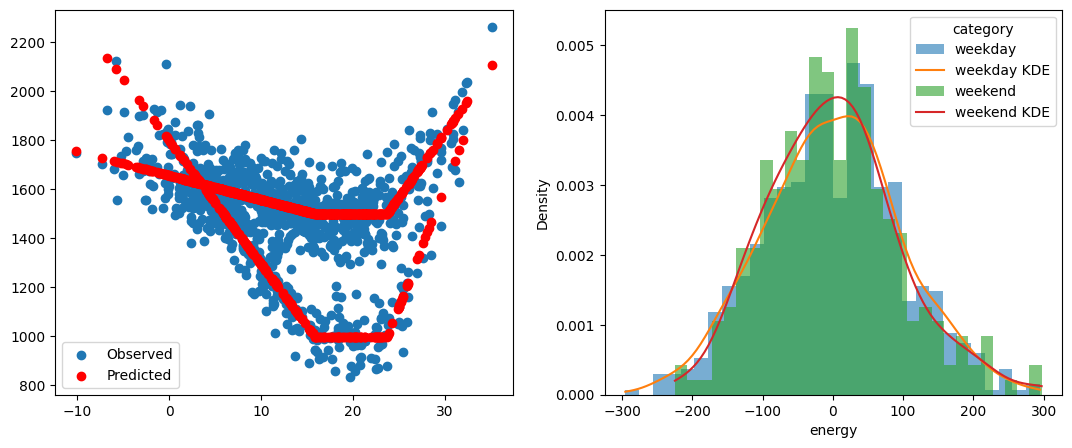

In [27]:
from scipy.stats import gaussian_kde
import numpy as np

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 5))
ax1.scatter(data["T"], data["energy"], label="Observed")
ax1.scatter(data["T"], ts_cat.model.predict(), label="Predicted", color="r")
ax1.legend()

error = data["energy"] - ts_cat.model.predict()
error = pd.concat([error, data["category"]], axis=1)

categories = error["category"].unique()

for category in categories:
    subset = error[error["category"] == category]
    ax2.hist(
        subset["energy"],
        bins=30,
        alpha=0.6,
        label=category,
        density=True
    )
    kde_data = gaussian_kde(subset["energy"])
    x_vals = np.linspace(subset["energy"].min(), subset["energy"].max(), 100)
    ax2.plot(x_vals, kde_data(x_vals), label=f'{category} KDE')

ax2.set_xlabel("energy")
ax2.set_ylabel("Density")
ax2.legend(title="category");

# Automatic detection of the category to use

In [28]:
from energy_toolbox.thermosensitivity.daily_analysis import (
    AutoCategoricalThermoSensitivity,
)

In [29]:
data = data = my_cat_synthtisor.random_consumption(
    start="2021-09-01", end="2024-04-17", size=None
)


ts = AutoCategoricalThermoSensitivity(
    energy_data=data["energy"],
    temperature_data=data["T"],
    degree_days_type="auto",
    degree_days_computation_method="mean",
)

ts.fit()

AutoCategoricalThermoSensitivity(frequency=1D,
        degree_days_type=both,
        degree_days_base_temperature={'heating': np.float64(17.07), 'cooling': np.float64(24.71)},
        degree_days_computation_method=mean,
        interseason_mean_temperature=20)

                            OLS Regression Results                            
Dep. Variable:                 energy   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.810
No. Observations:                 960   F-statistic:                     205.8
Covariance Type:            nonrobust   Prob (F-statistic):               0.00
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
heating_degree_days:Friday       11.2531      1.557      7.227      0.000       8.197      14.309
heating_degree_days:Monday       10.8321      1

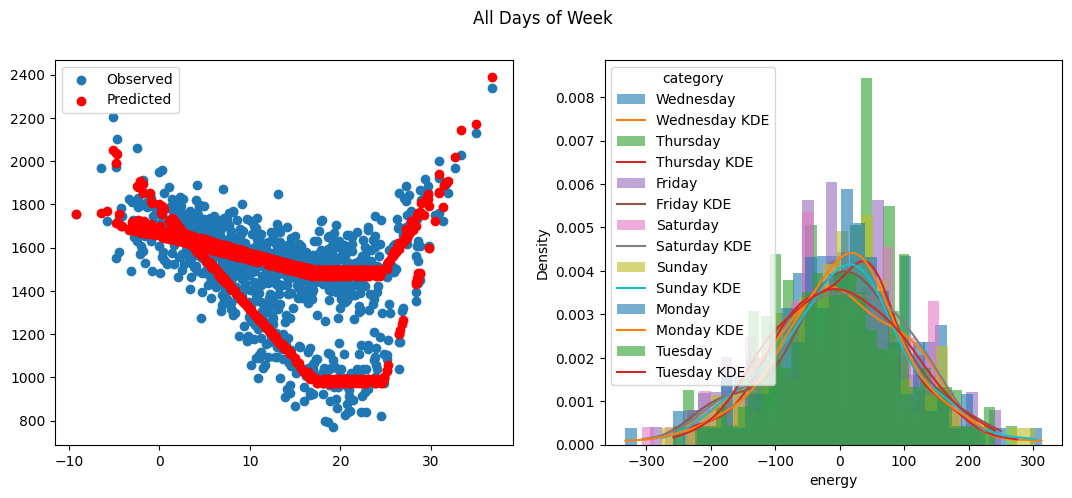

In [30]:
# display(ts_no_cat.model.summary())
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 5))
ax1.scatter(ts.resampled_temperature, ts.resampled_energy, label="Observed")
ax1.scatter(ts.resampled_temperature, ts.model.predict(), label="Predicted", color="r")
ax1.legend()

error = ts.resampled_energy - ts.model.predict()
error = pd.concat([error, ts.resampled_categories], axis=1)

categories = error["category"].unique()

for category in categories:
    subset = error[error["category"] == category]
    ax2.hist(
        subset["energy"],
        bins=30,
        alpha=0.6,
        label=category,
        density=True
    )
    kde_data = gaussian_kde(subset["energy"])
    x_vals = np.linspace(subset["energy"].min(), subset["energy"].max(), 100)
    ax2.plot(x_vals, kde_data(x_vals), label=f'{category} KDE')

ax2.set_xlabel("energy")
ax2.set_ylabel("Density")
ax2.legend(title="category")

fig.suptitle("All Days of Week");

In [31]:
ts.merge_and_fit()

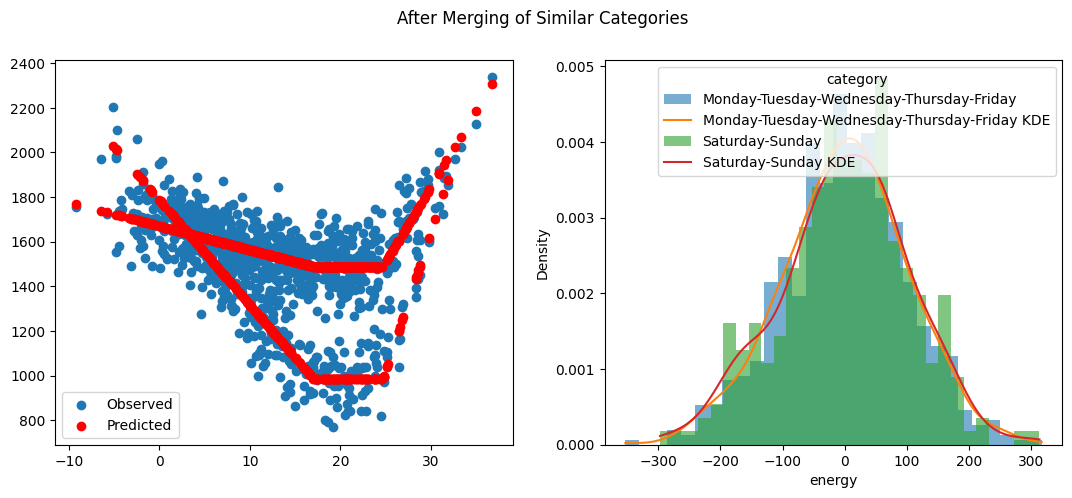

In [32]:
# display(ts_no_cat.model.summary())
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 5))
ax1.scatter(ts.resampled_temperature, ts.resampled_energy, label="Observed")
ax1.scatter(ts.resampled_temperature, ts.model.predict(), label="Predicted", color="r")
ax1.legend()

error = ts.resampled_energy - ts.model.predict()
error = pd.concat([error, ts.resampled_categories], axis=1)
categories = error["category"].unique()

for category in categories:
    subset = error[error["category"] == category]
    ax2.hist(
        subset["energy"],
        bins=30,
        alpha=0.6,
        label=category,
        density=True
    )

    # KDE
    kde_data = gaussian_kde(subset["energy"])
    x_vals = np.linspace(subset["energy"].min(), subset["energy"].max(), 100)
    ax2.plot(x_vals, kde_data(x_vals), label=f'{category} KDE')

ax2.set_xlabel("energy")
ax2.set_ylabel("Density")
ax2.legend(title="category")
fig.suptitle("After Merging of Similar Categories");

As expected, the days with the same categories are similare. Lets see if the model can capture the difference between the days.

# Conclusion

We have seen how we can analyse the consumption of a building depending even with different thermo-sensitivity depending on the day.

However, we still need to see how the model behaves in the presence of labeling errors. Typically, we could have a day that is labeled as a weekend day but that is actually with a week day behavior.